## 1. Import Libraries

Necessary libraries to execute the code

In [1]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import locale
locale.setlocale(locale.LC_ALL, '')
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## 2. Data Import
The following code cell is used to download the dataset files from the Kaggle website. It only needs to be executed once.  
Additionally, you will need to generate a personal Kaggle API Token in your account settings and install kaggle (pip install kaggle). 
In my case, when generating the Token, it was not automatically saved locally, so I created the json file manually and saved it in the .Kaggle folder in users. It follows this structure: 
{
    "username": "your_username",
    "key": "copy the API TOKEN the first time is generated, or not visible anymore"
}

In [4]:
#def download_kaggle_dataset(dataset, path="data"):
     #if not os.path.exists(path):
         #os.makedirs(path)

     #api = KaggleApi()
     #api.authenticate()
     #api.dataset_download_files(dataset, path=path, unzip=True)
     #print("Dataset downloaded and extracted.")

#if __name__ == "__main__":
    #download_kaggle_dataset("barun2104/telecom-churn")

In [2]:
df=pd.read_csv('data/telecom_churn.csv')
print(df)
print("Dataset Columns: \n")
print(df.columns)

      Churn  AccountWeeks  ContractRenewal  DataPlan  DataUsage  \
0         0           128                1         1       2.70   
1         0           107                1         1       3.70   
2         0           137                1         0       0.00   
3         0            84                0         0       0.00   
4         0            75                0         0       0.00   
...     ...           ...              ...       ...        ...   
3328      0           192                1         1       2.67   
3329      0            68                1         0       0.34   
3330      0            28                1         0       0.00   
3331      0           184                0         0       0.00   
3332      0            74                1         1       3.70   

      CustServCalls  DayMins  DayCalls  MonthlyCharge  OverageFee  RoamMins  
0                 1    265.1       110           89.0        9.87      10.0  
1                 1    161.6       123 

**ATTRIBUTES DESCRIPTION**
- Churn = The target variable indicating whether a customer canceled their service (1 = Yes, 0 = No)
- AccountWeeks = The number of weeks the customer has had an active account with the telecom provider
- ContractRenewal = A binary indicator of recent loyalty (1 if the customer recently renewed their contract, and 0 if they did not)
- DataPlan = Indicates if the customer has a data plan (1 = Yes, 0 = No)
- DataUsage = The amount of mobile data used by the customer, typically measured in gigabytes (GB) per month
- CustServCalls = The total number of calls made by the customer to customer service; high numbers often correlate with dissatisfaction
- DayMins = The average number of minutes the customer spends on calls during daytime hours each month
- DayCalls = The average number of distinct calls made by the customer during daytime hours
- MonthlyCharge = The average monthly bill amount charged to the customer
- OverageFee = The highest overage fee recorded for the customer in the last 12 months due to exceeding plan limits
- RoamMins = The average number of minutes spent on roaming (calls made outside the home network area) per month


## Data Profiling
From this profiling we understand that we have 3332 rows of actual data (3333 considering the first row for attributes). We luckily don't have missing values nor duplicates. 

In [3]:
print("\nDataset Info: \n")
print(df.info())
print("\nMissing Values: \n")
print(df.isnull().sum()) 
print("\nDuplicate Values: \n")
print(df.duplicated().sum())
print("\nDescriptive Statistics:")
print(df.describe())


Dataset Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3333 non-null   int64  
 1   AccountWeeks     3333 non-null   int64  
 2   ContractRenewal  3333 non-null   int64  
 3   DataPlan         3333 non-null   int64  
 4   DataUsage        3333 non-null   float64
 5   CustServCalls    3333 non-null   int64  
 6   DayMins          3333 non-null   float64
 7   DayCalls         3333 non-null   int64  
 8   MonthlyCharge    3333 non-null   float64
 9   OverageFee       3333 non-null   float64
 10  RoamMins         3333 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 286.6 KB
None

Missing Values: 

Churn              0
AccountWeeks       0
ContractRenewal    0
DataPlan           0
DataUsage          0
CustServCalls      0
DayMins            0
DayCalls           0
MonthlyCharge      0
OverageFee   

Instead of just spotting the insights in the descriptive statistics manually, we can exploit some Python libraries useful for Exploratory Data Analysis (EDA) as a bridge between descriptive statistics and ML workflow, such as *seaborn* and *matplotlib*. 

**1. VISUALIZE CLASS IMBALANCE (CHURN RATE)**
It matters because if the churn group is too small, the ML model might struggle to learn their behavior. In this context, around 500 items is enough if careful when choosing the evaluation method.

Churn
0    85.508551
1    14.491449
Name: proportion, dtype: float64


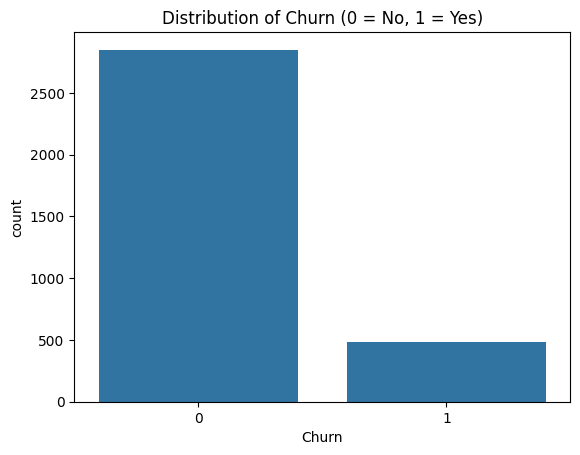

In [4]:
# Formula to see the exact counts and percentage
print(df['Churn'].value_counts(normalize=True) * 100)

sns.countplot(x='Churn', data=df)
plt.title('Distribution of Churn (0 = No, 1 = Yes)')
plt.show()

**2. IDENTIFY CORRELATIONS**
We can verify which attributes are most connected to the churn without checking each one manually with a heatmap.
Of course, we get some trivial insights, such as a positive and strong correlation between DataUsage and DataPlan or DataUsage and MonthlyCharge. 
With a combination of data filtering and correlation analysis, we can find some deeper insights to verify important correlations with the churn tendency (*see after the heatmap*)

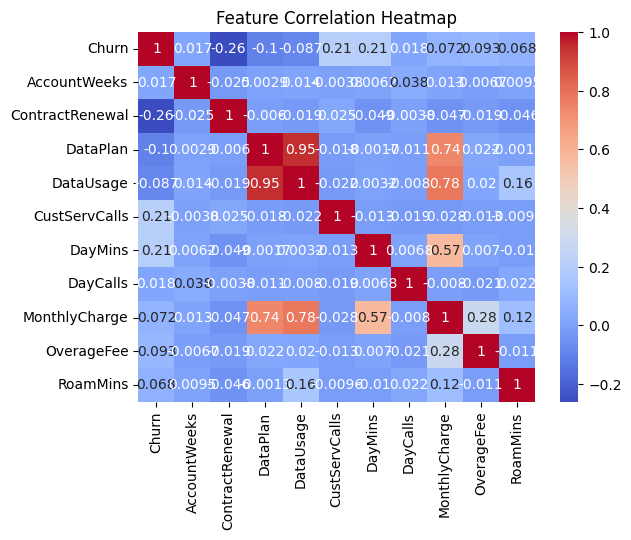

In [5]:
# Formula to see which features relate most to Churn
correlation = df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [6]:
# Step 1: Filter the dataframe for only loyal customers (Churn == 0)
loyal_customers = df[df['Churn'] == 0]

# Step 2: Select the 'CustServCalls' column from that group and find the mean
avg_calls = loyal_customers['CustServCalls'].mean()

print("Average of Calls made by loyal customers (no churn): ", round(avg_calls,2))

Average of Calls made by loyal customers (no churn):  1.45


In [7]:
# Do the inverse for customers that quit
churned_customers = df[df['Churn'] == 1]
avg_calls = churned_customers['CustServCalls'].mean()
print ("Average of Calls made by churned customers (no churn): ", round(avg_calls,2))

Average of Calls made by churned customers (no churn):  2.23


If CustServCalls has a correlation of 0.21 with Churn, it means as calls increase, the likelihood of churn also increases. It might seem a small number in absolute terms, but it is an interesting finding for this type of data, also because it is the highest we can find in relation to churn in the matrix. The value 1.45 is the mean of the CustServCalls column, but only for the rows where the customer did not churn. Correlation measures the linear strength of the relationship across the entire dataset, but the averages tell the story of the groups, because the 2.23 instead underlines a 54% increase in the in call volume for the churn group, so the correlation is numerically low but the physical reality is still impactiful. 

**The Heavy Users Paradox**
In many industries, you might expect unhappy customers to be those who don't use the service much, but this dataset shows the opposite. By looking at the Avg DayMins, there is a clear difference between loyal and churned clients. Churners talk about 18% more during the day than loyal customers, so they are also being billed more. 

In [8]:
loyal_customers = df[df['Churn'] == 0]
avg_mins = loyal_customers['DayMins'].mean()
print ("Average Minutes per Day of service usage for loyal customers: ", int(avg_mins))

Average Minutes per Day of service usage for loyal customers:  175


In [9]:
churned_customers = df[df['Churn'] == 1]
avg_mins = churned_customers['DayMins'].mean()
print ("Average Minutes per Day of service usage for churned customers: ", int(avg_mins))

Average Minutes per Day of service usage for churned customers:  206


In [10]:
loyal_customers = df[df['Churn'] == 0]
avg_monchar = loyal_customers['MonthlyCharge'].mean()
print ("Average Monthly Charge for loyal customers: ", locale.currency(round(avg_monchar,2), grouping=True))

Average Monthly Charge for loyal customers:  55,82 €


In [11]:
churned_customers = df[df['Churn'] == 1]
avg_monchar = churned_customers['MonthlyCharge'].mean()
print ("Average Monthly Charge for churned customers: ", locale.currency(round(avg_monchar,2), grouping=True))

Average Monthly Charge for churned customers:  59,19 €


In [12]:
loyal_customers = df[df['Churn'] == 0]
avg_overfee = loyal_customers['OverageFee'].mean()
print ("Average Overage Fee for loyal customers: ", locale.currency(round(avg_overfee,2), grouping=True))

Average Overage Fee for loyal customers:  9,95 €


In [13]:
churned_customers = df[df['Churn'] == 1]
avg_overfee = churned_customers['OverageFee'].mean()
print ("Average Overage Fee for churned customers: ", locale.currency(round(avg_overfee,2), grouping=True))

Average Overage Fee for churned customers:  10,62 €


The Usage Intensity insight reveals a specific business problem: the most active users that therefore generate the most revenue are the ones leaving. If someone uses a lot of minutes and sees high monthly charges plus overage fees, is more prone to look for better alternatives by competitors. Usually, high usage is seen as engagement, but in this dataset high usage is actually a warning sign that the customer might find a better deal elsewhere.

## DATA PREPROCESSING
### DATA CLEANING
We don't deal with missing or duplicate values. Anyways, we can apply dimensionality reduction and feature engineering to exploit high correlation that does not reach a threshold such that we can directly drop one.  

In [28]:
# Dimensionality Reduction
# Dropping 'DataPlan' because 'DataUsage' provides the same info but with higher granularity
df = df.drop(columns=['DataPlan'])

# Feature Engineering: Merging Redundant Attributes
# Creating 'PricePerMinute' merges the financial impact of 'MonthlyCharge' with the usage in 'DayMins'
# We add a tiny value (1e-9) to avoid DivisionByZero errors if a customer has 0 DayMins
df['PricePerMinute'] = df['MonthlyCharge'] / (df['DayMins']+ 1e-9)

# Dropping 'MonthlyCharge' since it is a "resultant" feature from mins, data and overage used in a month
df = df.drop(columns=['MonthlyCharge'])

# Verify the changes
print(f"New column count: {len(df.columns)}")
print(df[['DayMins', 'PricePerMinute']].head())



New column count: 10
   DayMins  PricePerMinute
0    265.1        0.335722
1    161.6        0.507426
2    243.4        0.213640
3    299.4        0.190381
4    166.7        0.245951


During preprocessing, we can run a quick RandomForest just to see the Feature Importance chart to guide attribute seleciton. To make it effective, we set some parameters first, like *class_weight='balance'* because we only have 14.5% of the customers churned, and this tells the mforest to pay more attention to those individuals so their behavior isn't ignored; the *n_estimators=100* as standard tradeoff between stable importance score and time spent; the *random_state=42* to ensure that every time we run the code we get the same importance score not to randomly change conclusions. 
In machine learning, a common rule of thumb for feature selection is to keep attributes that contribute at least 5% (0.05) to the model's decision-making. 

In [29]:
# 1. Prepare Features (X) and Target (y)
# We drop Churn (target) and the redundant columns we identified earlier
X = df.drop(columns=['Churn'])
y = df['Churn']

# 2. Split the data
# Even for importance, splitting ensures the model doesn't just "memorize" the whole set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Set up and Train the Random Forest
# Note the 'class_weight' parameter to handle the 14.5% churn imbalance
rf_selector = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_selector.fit(X_train, y_train)

# 4. Extract and visualize the results
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_selector.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importances)

           Feature  Importance
4          DayMins    0.241669
3    CustServCalls    0.172419
6       OverageFee    0.119545
8   PricePerMinute    0.116188
1  ContractRenewal    0.103078
7         RoamMins    0.066896
5         DayCalls    0.063417
0     AccountWeeks    0.062841
2        DataUsage    0.053947


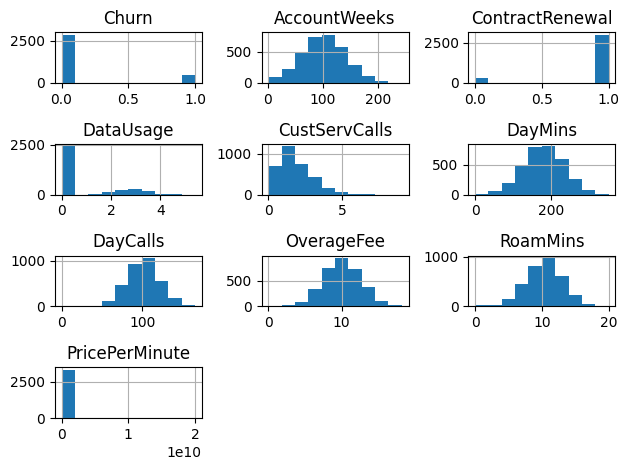

In [30]:
#histogram to show density and distribution
df.hist()
plt.tight_layout()

### Outlier Detection

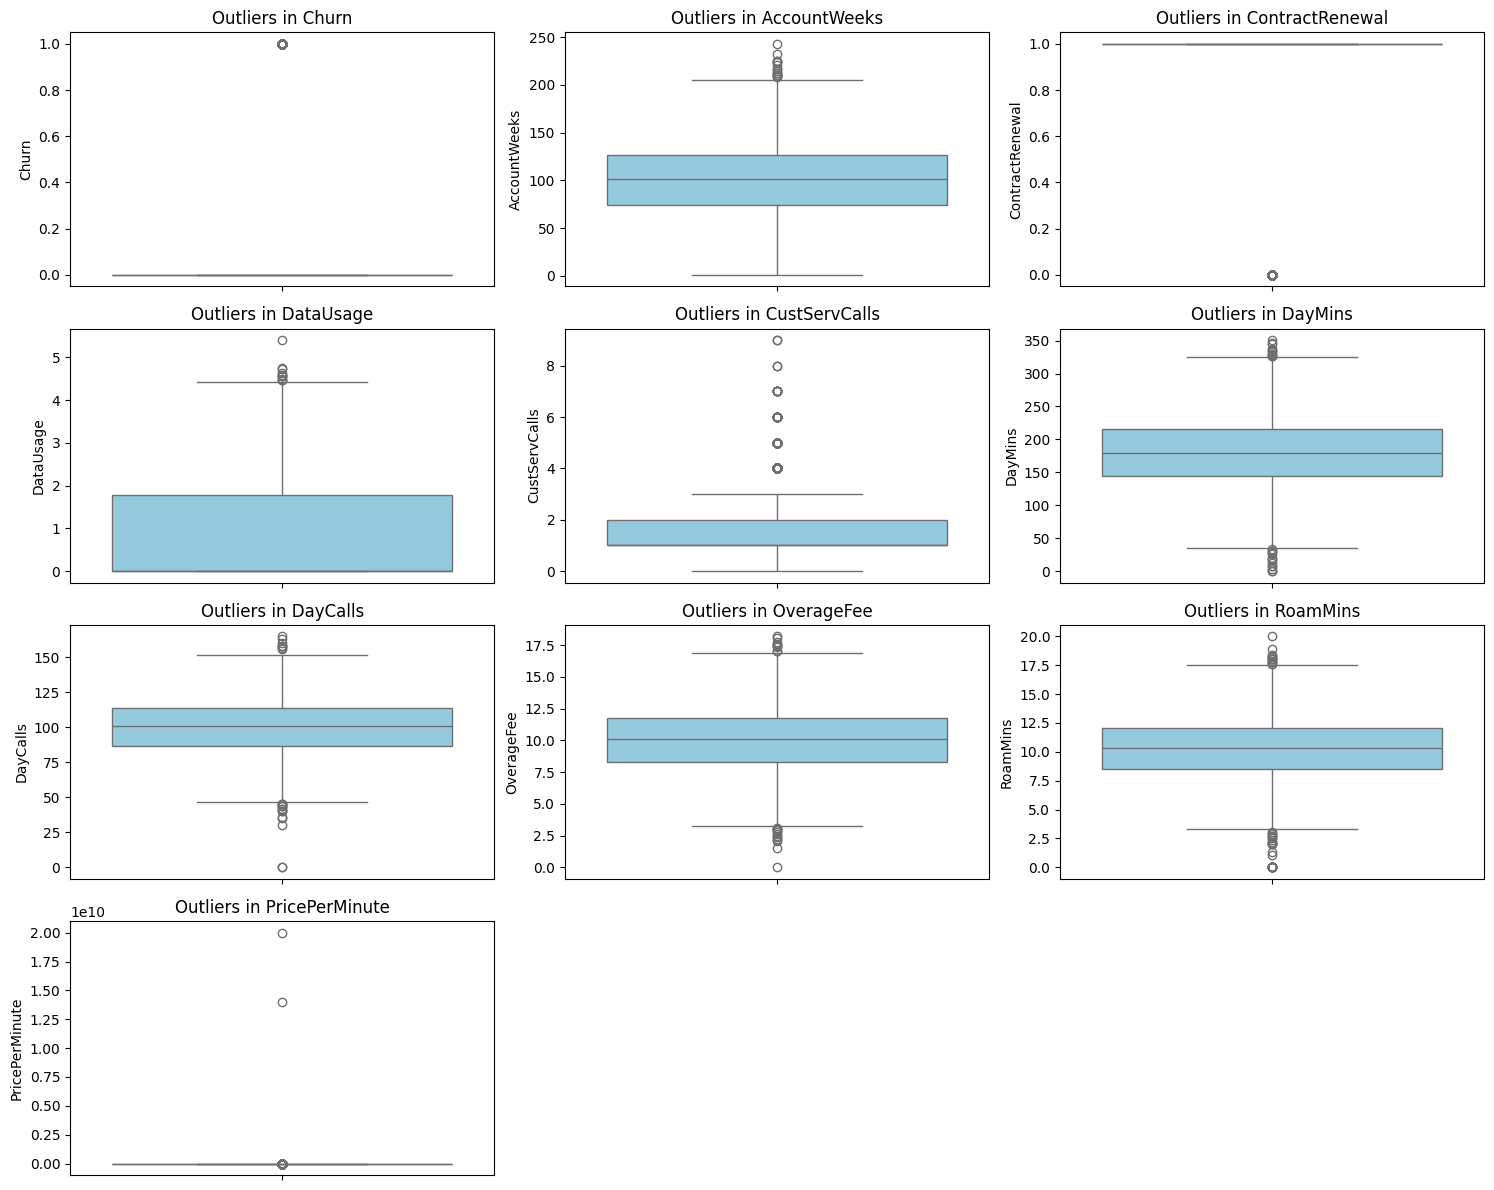

In [16]:
# Select only numeric columns for analysis
numeric_cols = df.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(15, 12))
for i, col in enumerate(numeric_cols):
    plt.subplot(4, 3, i+1)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(f'Outliers in {col}')
plt.tight_layout()
plt.show()

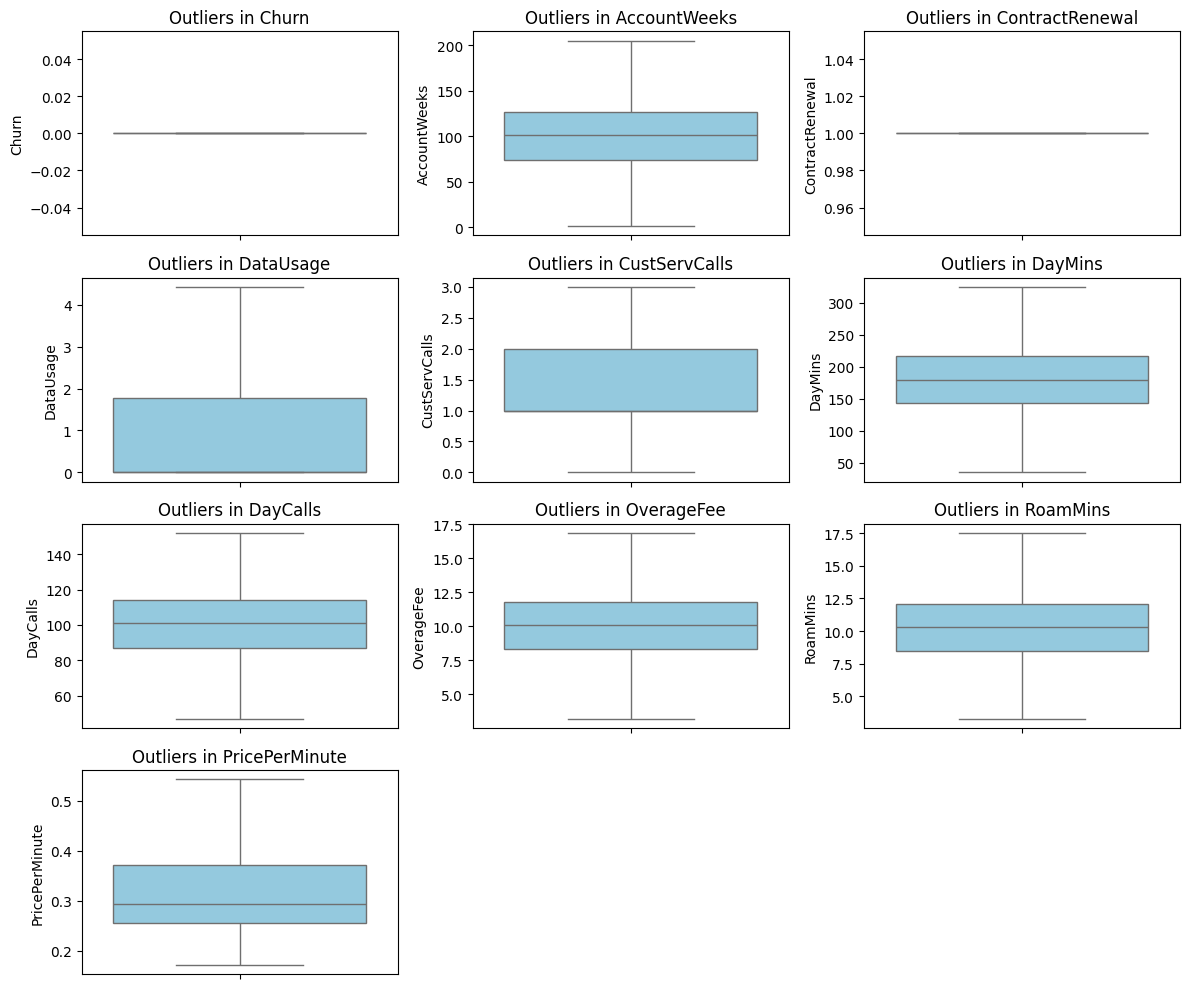

In [18]:
plt.figure(figsize=(12, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(4, 3, i+1)
    sns.boxplot(y=df[col], showfliers=False, color='skyblue')
    plt.title(f'Outliers in {col}')
plt.tight_layout()
plt.show()

In [20]:
def outlier_report(data):
    report = []
    for col in data.select_dtypes(include=[np.number]).columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        
        count = ((data[col] < lower) | (data[col] > upper)).sum()
        report.append({
            'Feature': col,
            'Outliers': count,
            'Lower Bound': round(lower, 2),
            'Upper Bound': round(upper, 2)
        })
    return pd.DataFrame(report).sort_values(by='Outliers', ascending=False)

print(outlier_report(df))

           Feature  Outliers  Lower Bound  Upper Bound
0            Churn       483         0.00         0.00
2  ContractRenewal       323         1.00         1.00
4    CustServCalls       267        -0.50         3.50
9   PricePerMinute       175         0.08         0.54
8         RoamMins        46         3.10        17.50
5          DayMins        25        34.65       325.45
7       OverageFee        24         3.17        16.93
6         DayCalls        23        46.50       154.50
1     AccountWeeks        18        -5.50       206.50
3        DataUsage        11        -2.67         4.45


PricePerMinute (Upper Bound: 0.54): Customers paying over 54 cents per minute are outliers. We should check if these are real (heavy roaming users) or if they represent data errors.

DayMins (Lower Bound: 34.6): Customers who talk less than 34 minutes a month are outliers. If their MonthlyCharge is still high, they are at very high risk of leaving because they aren't getting value.

In [ ]:
# Reload original dataset to see the full context
df_orig = pd.read_csv('data/telecom_churn.csv')

# Check the "Expensive" outliers
ppm_threshold = 0.54
expensive_customers = df_orig[df_orig['MonthlyCharge'] / (df_orig['DayMins'] + 1e-9) > ppm_threshold]

print("Expensive outliers who are actually Data Users:")
print(expensive_customers[expensive_customers['DataUsage'] > 1.0].head())

# High Minute Users vs churn
print("\nHigh Minute Users and their Churn status:")
print(df_orig[df_orig['DayMins'] > 325][['DayMins', 'CustServCalls', 'Churn']])

Expensive outliers who are actually Data Users:
     Churn  AccountWeeks  ContractRenewal  DataPlan  DataUsage  CustServCalls  \
115      1            36                0         1       5.40              0   
182      0            67                1         1       2.67              2   
200      0            53                1         1       3.54              3   
205      0            66                1         1       3.27              1   
246      0           107                1         1       3.00              0   

     DayMins  DayCalls  MonthlyCharge  OverageFee  RoamMins  
115    196.8        89          110.0       12.75      20.0  
182    115.6       111           66.7       11.89       9.9  
200    145.7       146           79.4       11.03      13.1  
205    106.7        76           68.7       10.49      12.1  
246     60.0       102           49.0        5.11      11.1  

High Minute Users and their Churn status:
      DayMins  CustServCalls  Churn
15      332.9 

ContractRenewal
1    3010
0     323
Name: count, dtype: int64


Text(0.5, 1.0, 'Frequency of Contract Renewals')

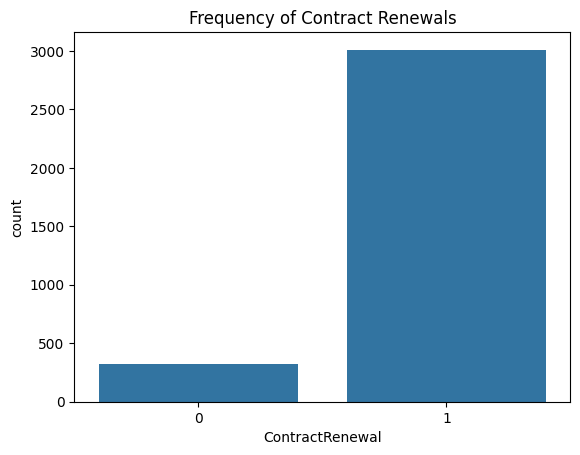

In [22]:
# The correct way to look at ContractRenewal
print(df['ContractRenewal'].value_counts())

# Or visually:
sns.countplot(x='ContractRenewal', data=df)
plt.title('Frequency of Contract Renewals')